In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [91]:
df = pd.read_csv('results.csv')
df

time  percentage_freon  flow  error_freon  error_co2  flowcell  slope
0    13:19               100  40.0     0.057478   0.000000         2   2483
1    13:19               100  40.0     0.057478   0.000000         3   2518
2    13:20               100  40.0     0.057478   0.000000         4   2679
3    13:20               100  40.0     0.057478   0.000000         5   2506
4    13:20               100  40.0     0.057478   0.000000         6   4334
..     ...               ...   ...          ...        ...       ...    ...
639  15:51                70   3.3    -0.078830  -0.159464        27   9563
640  15:51                70   3.3    -0.078830  -0.159464        28   9394
641  15:51                70   3.3    -0.078830  -0.159464        29   9446
642  15:52                70   3.3    -0.078830  -0.159464        30   9477
643  15:52                70   3.3    -0.078830  -0.159464        31   9538

[644 rows x 7 columns]

In [92]:
# Maximal MFC flow errors in %
print(f'Max error MFC flow freon: {max(df.error_freon):.2f} %')
print(f'Max error MFC flow CO2: {max(df.error_co2):.2f} %')

Max error MFC flow freon: 0.13 %
Max error MFC flow CO2: 0.05 %


In [93]:
def plot_raw_data(percentage_freon):
    first1 = first2 = first3 = True
    for ch in range(16):
        if ch in [0, 7]:
            # Skip, channels not measured (bad cables)
            continue
        for offset in range(2):
            nb_flowcell = 2*ch + offset
            df_flowcell = df[(df.flowcell == nb_flowcell) & 
                ( (df.percentage_freon == percentage_freon) | (df.percentage_freon == -1) )]
            df_flowcell = df_flowcell.sort_values(by = 'flow')
            if ch in [1, 2]:
                # 5mm flowcells
                plt.plot(df_flowcell.flow, df_flowcell.slope, 'g--.', alpha=0.7,
                    label='5mm flowcells (J24914a 2405)' if first1 else '_nolegend_')
                first1 = False
            elif ch in [3, 4]:
                # 3mm flowcells (J24914a)
                plt.plot(df_flowcell.flow, df_flowcell.slope, 'r--.', alpha=0.7,
                    label='3mm flowcells (J24914a)' if first2 else '_nolegend_')
                first2 = False
            else:
                # 3mm flowcell (J24914a 1602)
                plt.plot(df_flowcell.flow, df_flowcell.slope, 'b--.', alpha=0.7,
                    label='3mm flowcells (J24914a 1602)' if first3 else '_nolegend_')
                first3 = False
    plt.title(f'Raw data, {percentage_freon}% R134a')
    plt.xlabel('Flow (nl/h)')
    plt.ylabel('Slope (m°C/s)')
    plt.legend()
    plt.grid()
    plt.show()


def plot_curve_comparison(nb_flowcell, ax, perform_correction=False):
    for percentage_freon in [70, 100]:
        df_flowcell = df[(df.flowcell == nb_flowcell) & 
            ( (df.percentage_freon == percentage_freon) | (df.percentage_freon == -1) )]
        df_flowcell = df_flowcell.sort_values(by = 'flow')
        
        flows = list(df_flowcell['flow'])
        if perform_correction:
            flows = [flow*(1.221 if percentage_freon==100 else 1) for flow in flows]
        slopes = list(df_flowcell['slope'])
        ax.plot(slopes, flows, '--.', label=f'{percentage_freon}% R134a')
    ax.set_title(f'Raw data flowcell {nb_flowcell}')
    ax.legend()
    ax.grid()


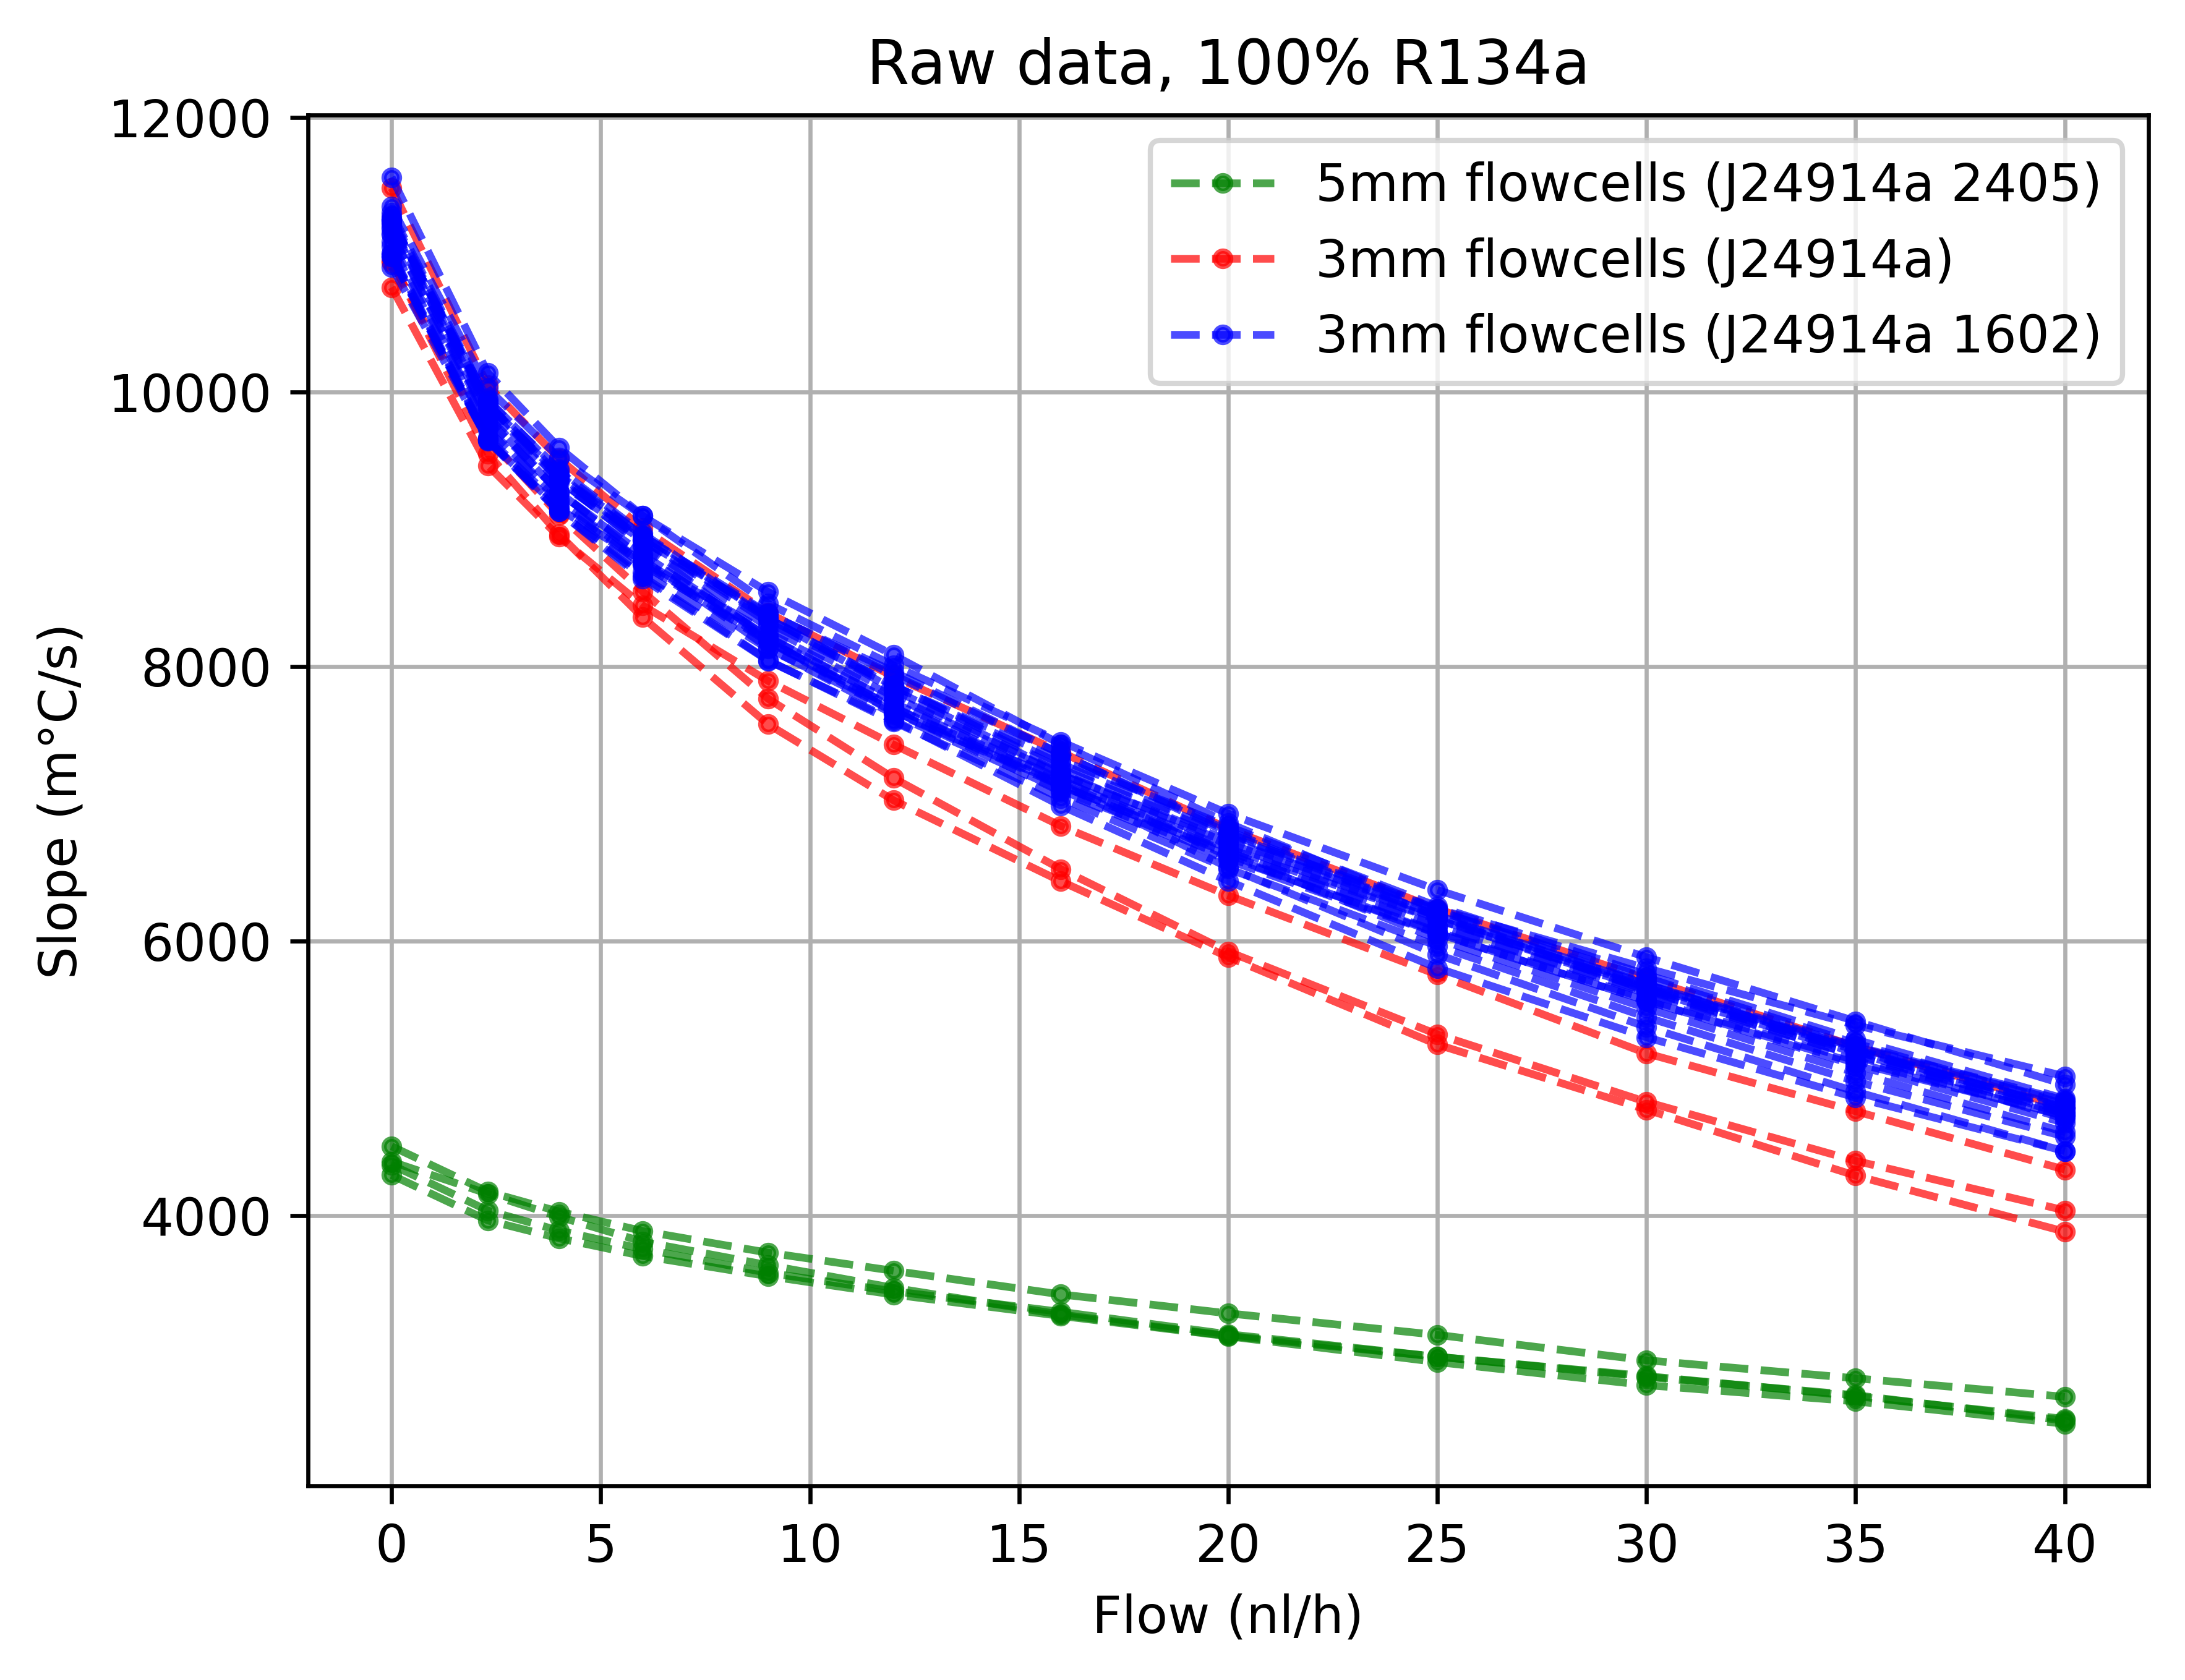

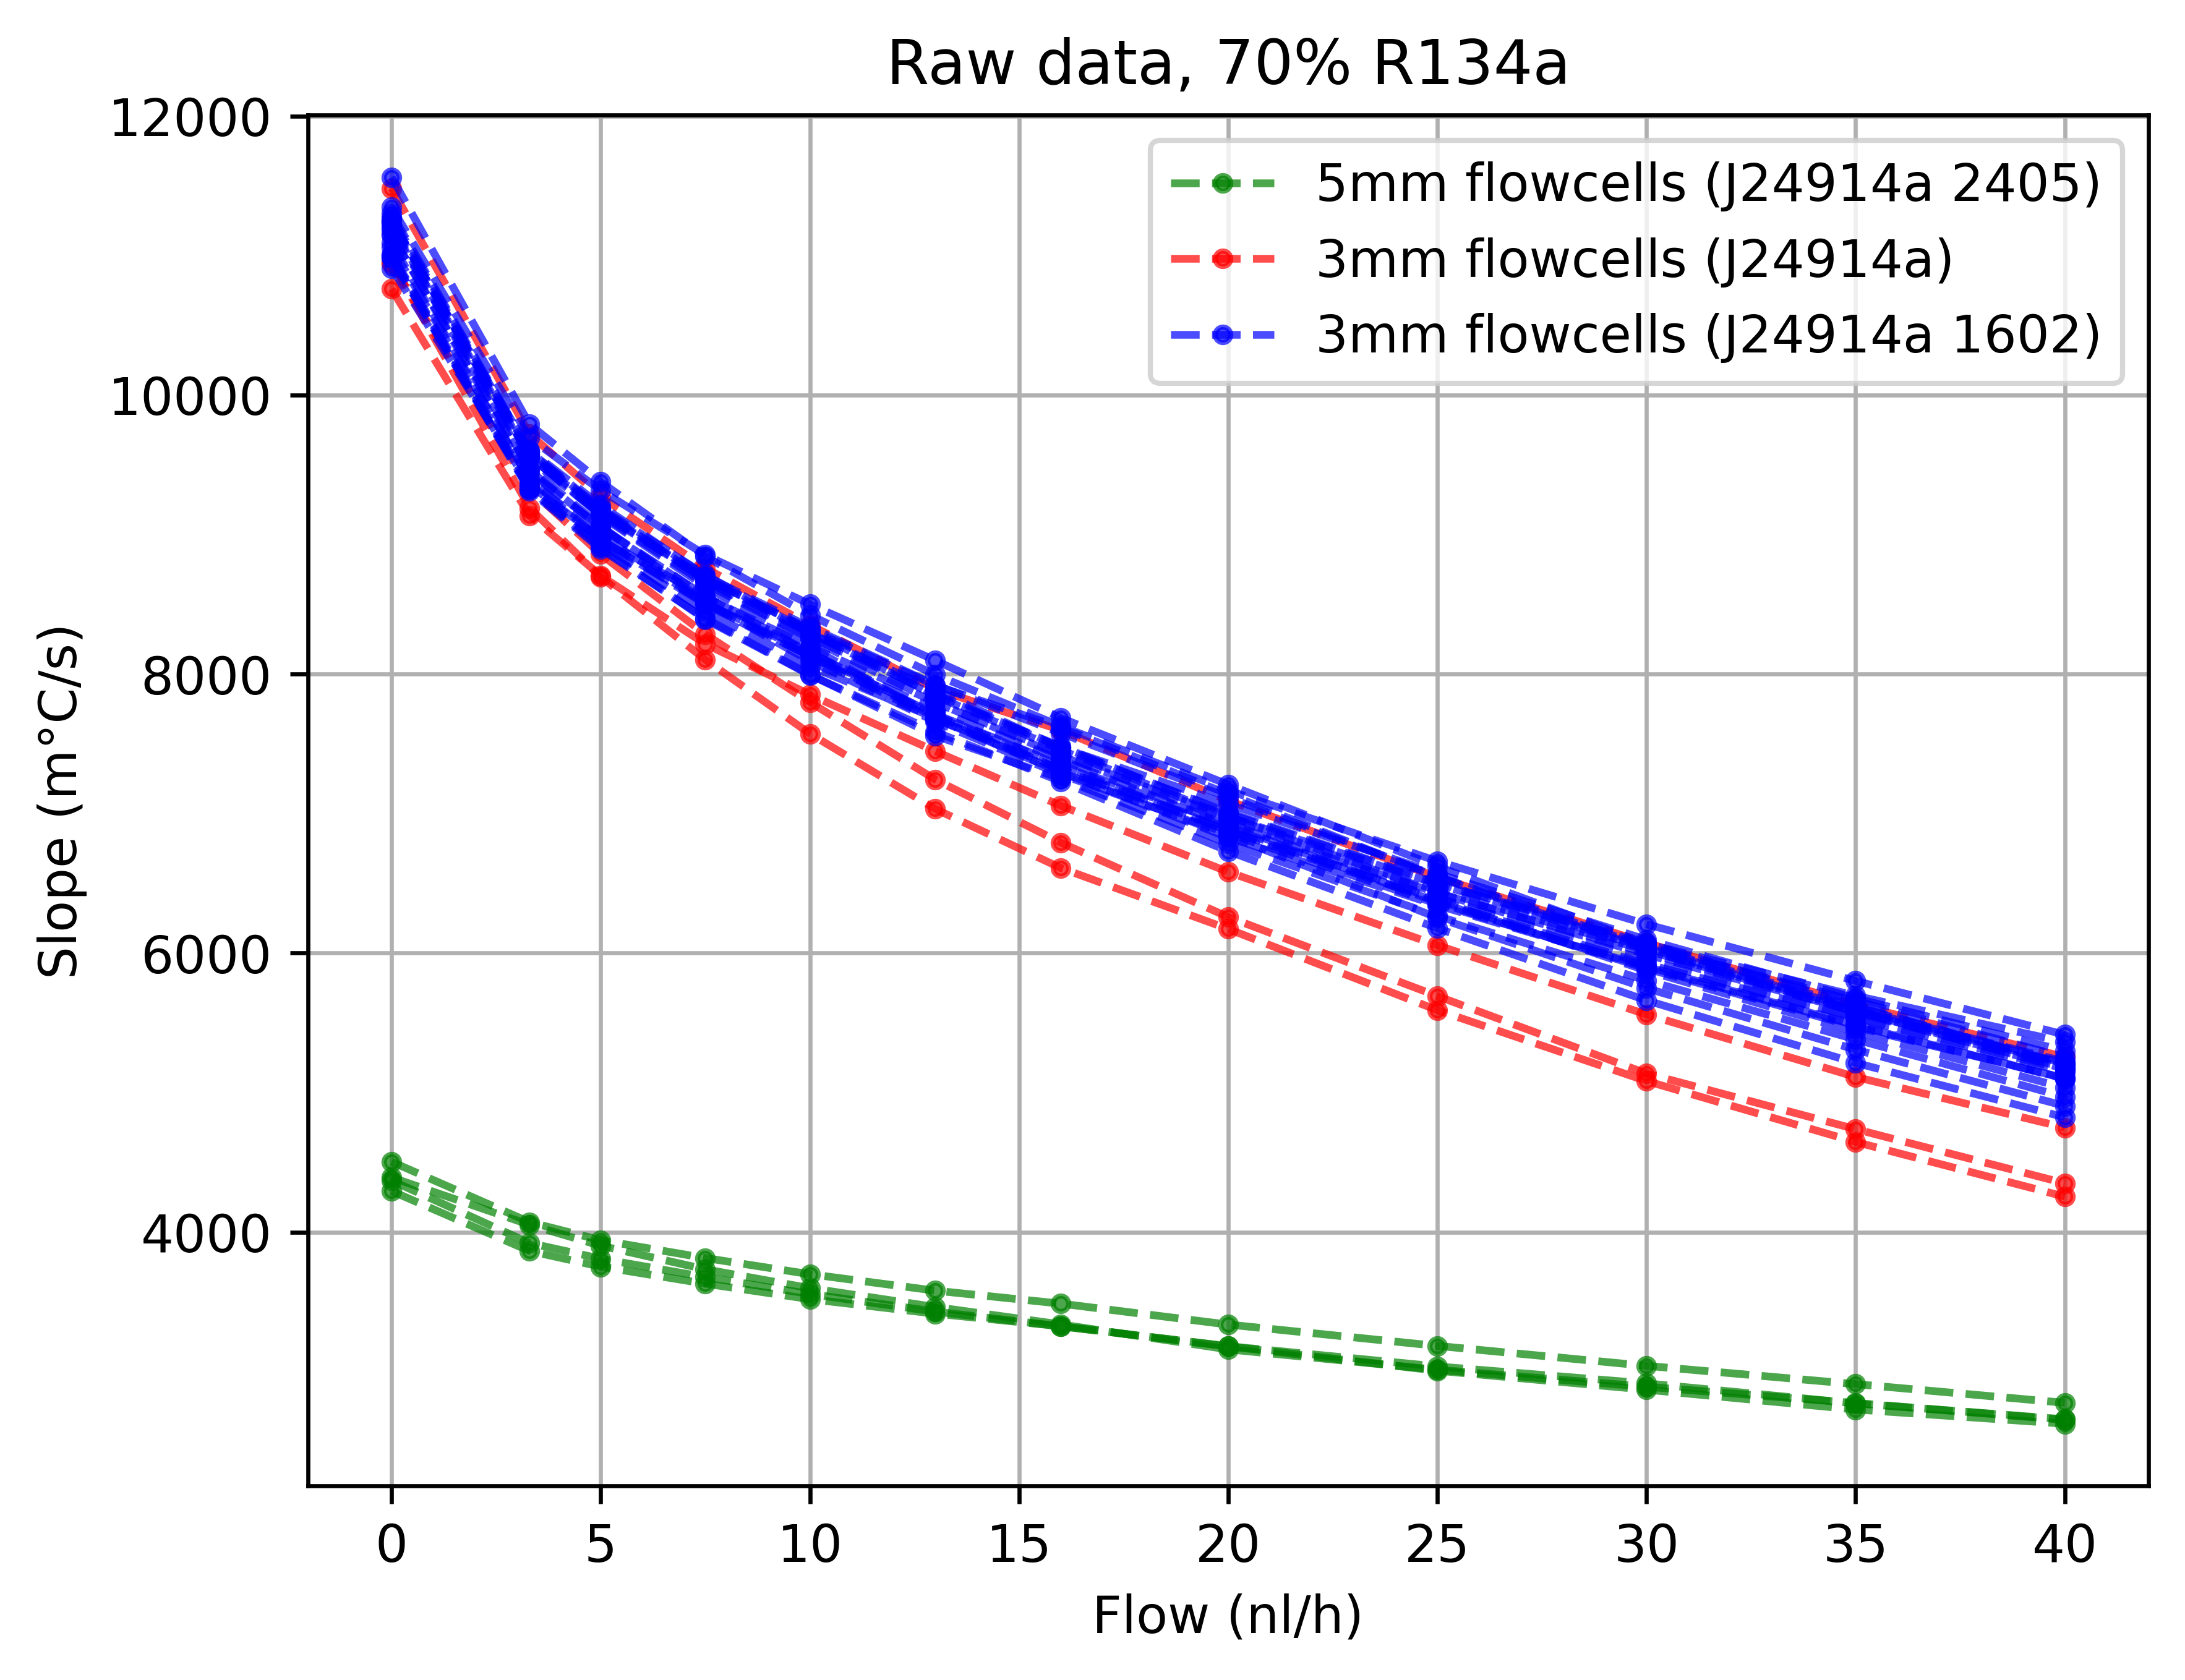

In [94]:
plot_raw_data(100)
plot_raw_data(70)

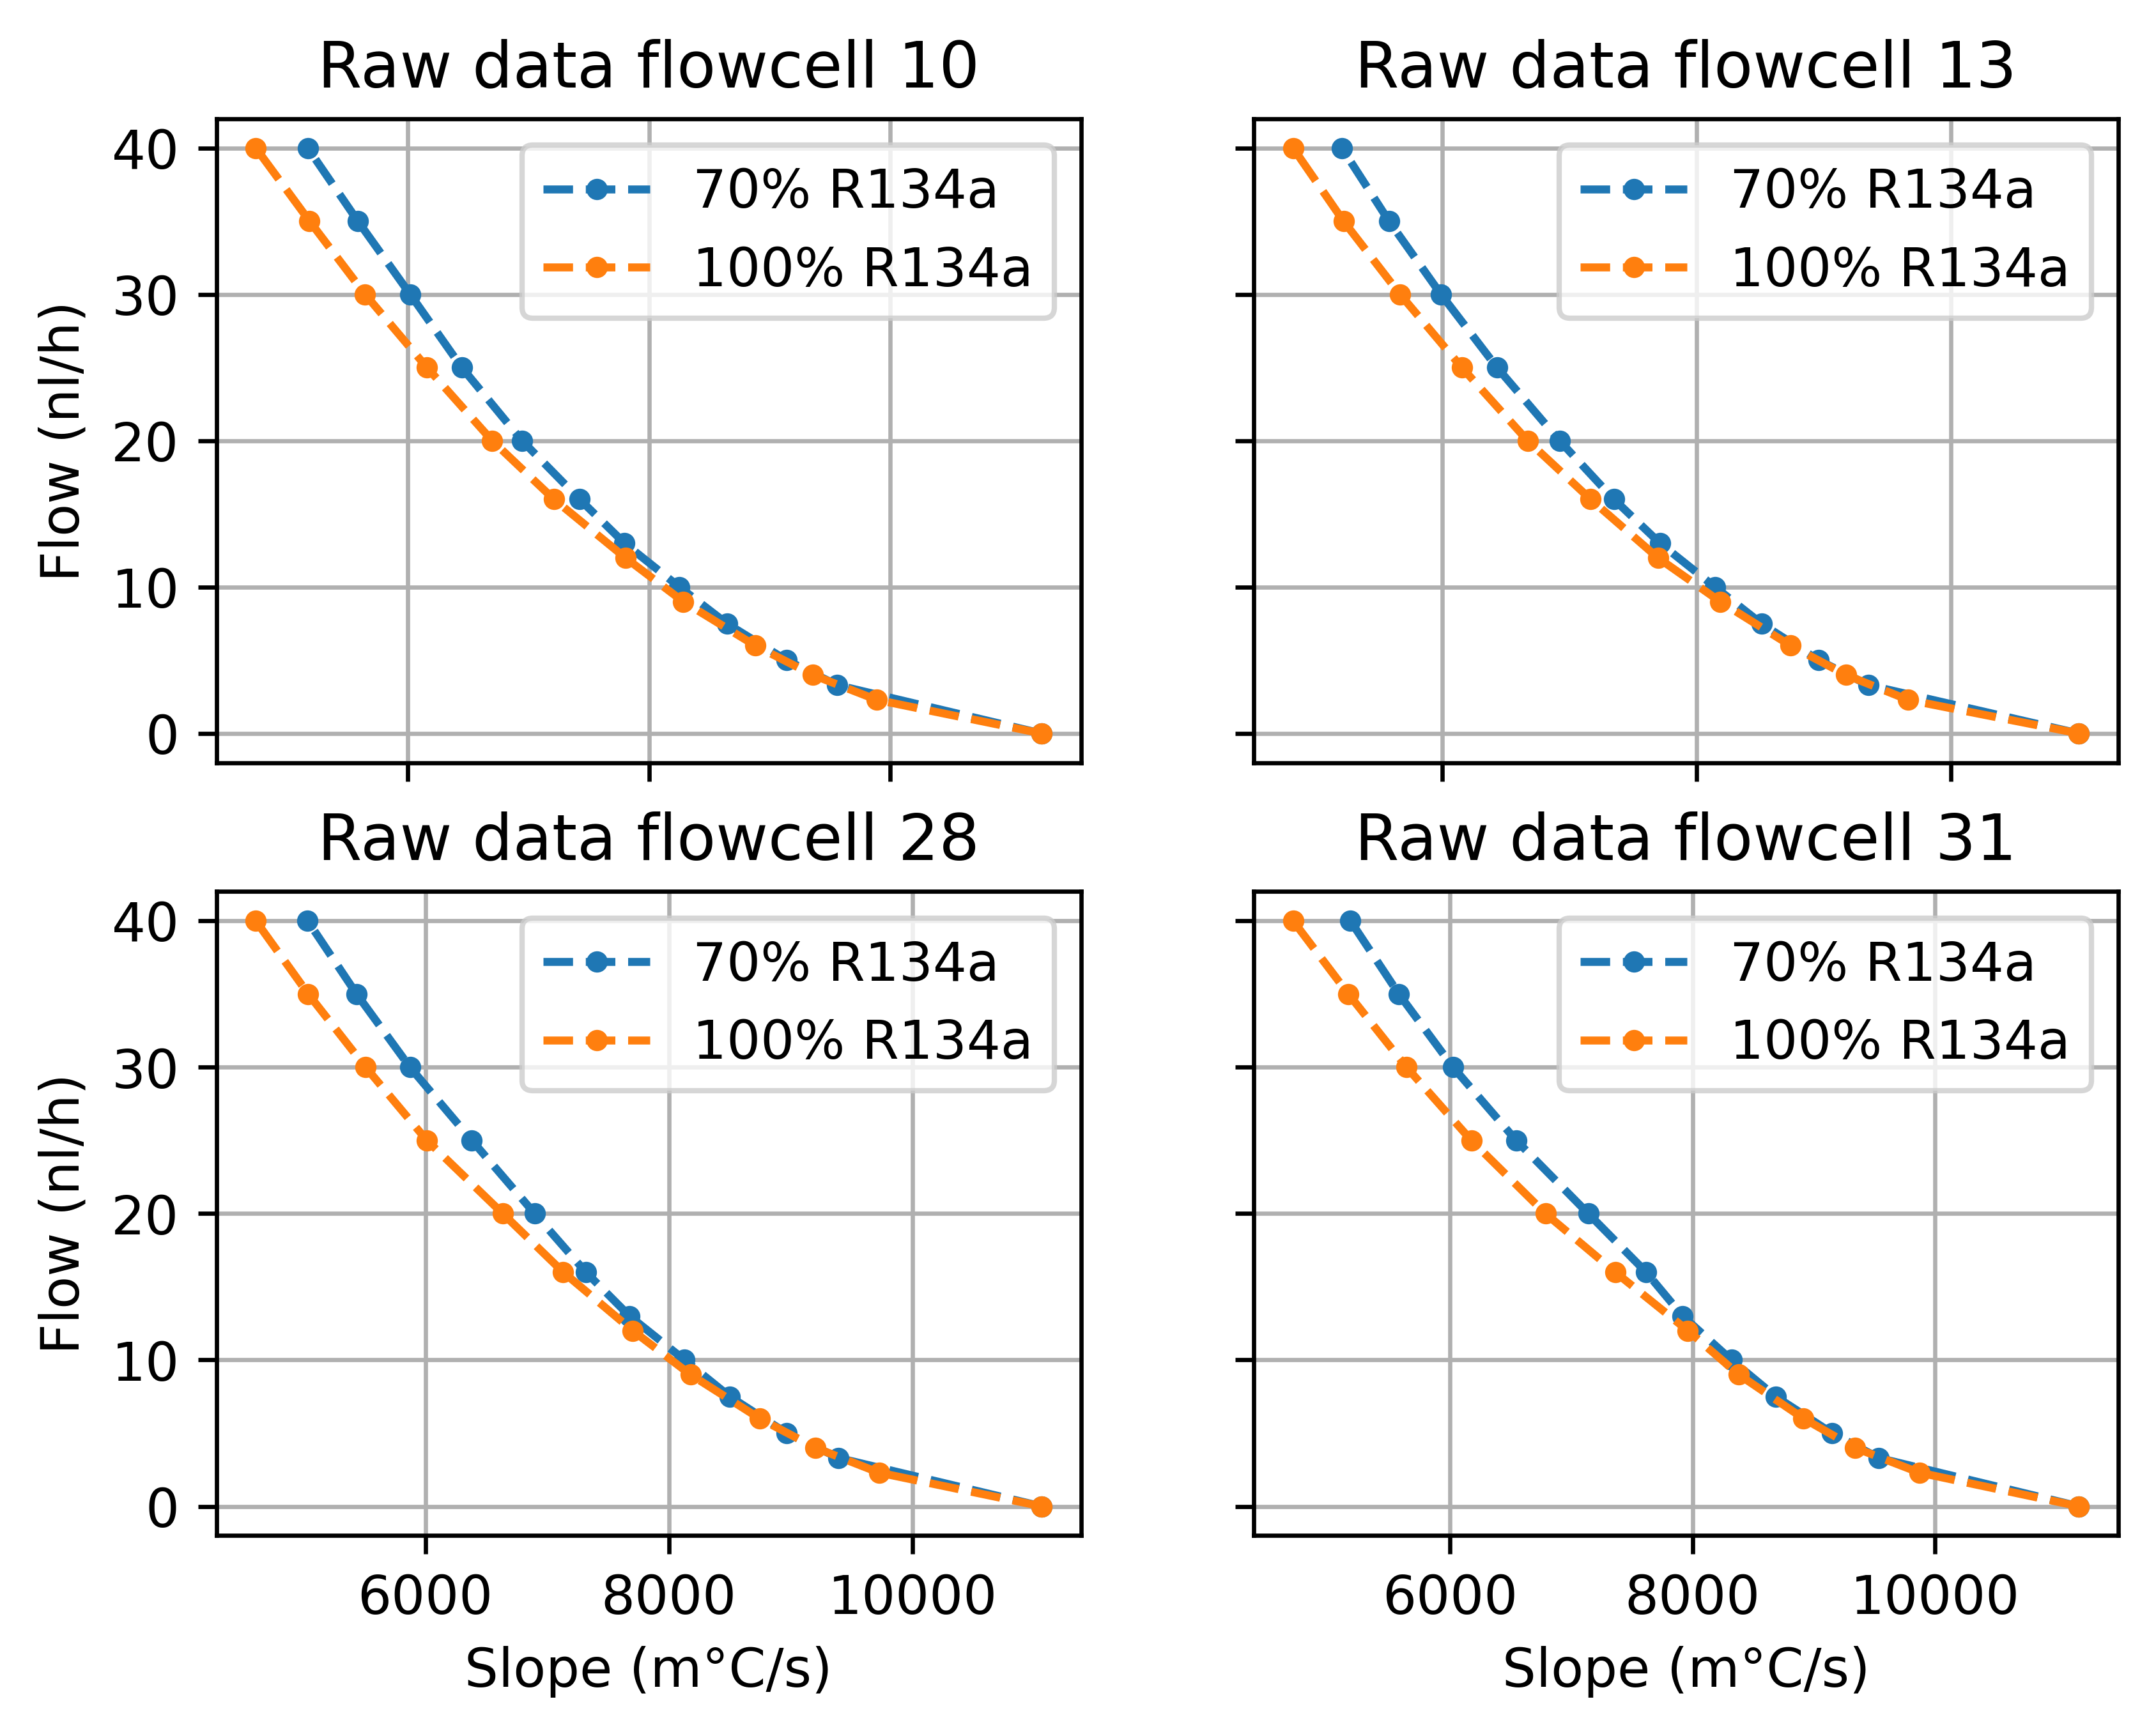

In [95]:
flowcell_nbs = [10, 13, 28, 31] # Some of the 3mm "1602" flowcells
# flowcell_nbs = [6, 7, 8, 9]
fig, axs = plt.subplots(2, 2)
for i in range(4):
    nb_flowcell = flowcell_nbs[i]
    plot_curve_comparison(nb_flowcell, axs[i//2, i%2])

for ax in axs.flat:
    ax.set(xlabel='Slope (m°C/s)', ylabel='Flow (nl/h)')
for ax in axs.flat:
    ax.label_outer()

In [96]:
def flow_to_slope(flow, nb_flowcell, percentage_freon, correction_factor=1):
    '''Map given flow to slope using linear interpolation.
    Optional correction factor for proposed correction (values of flows of pure freon can be increased with factor).'''
    df_flowcell = df[(df.flowcell == nb_flowcell) & 
        ( (df.percentage_freon == percentage_freon) | (df.percentage_freon == -1) )]
    df_flowcell = df_flowcell.sort_values(by = 'flow')
    flows = list(df_flowcell['flow'])
    flows = [flow*correction_factor for flow in flows]
    slopes = list(df_flowcell['slope'])
    # slopes = [slopes[0] + (slope-slopes[0])/correction_factor for slope in slopes]
    
    i = 0
    while True:
        if flow <= flows[i+1]:
            break
        i += 1
    return slopes[i] + (flow-flows[i]) * (slopes[i+1]-slopes[i])/(flows[i+1]-flows[i])

def slope_to_flow(slope, nb_flowcell, percentage_freon):
    '''Map given slope to flow using linear interpolation'''
    df_flowcell = df[(df.flowcell == nb_flowcell) & 
        ( (df.percentage_freon == percentage_freon) | (df.percentage_freon == -1) )]
    df_flowcell = df_flowcell.sort_values(by = 'flow')
    flows = list(df_flowcell['flow'])
    slopes = list(df_flowcell['slope'])
    i = 0
    while True:
        if slope >= slopes[i+1]:
            break
        i += 1
    return flows[i] + (slope-slopes[i]) * (flows[i+1]-flows[i])/(slopes[i+1]-slopes[i])
    

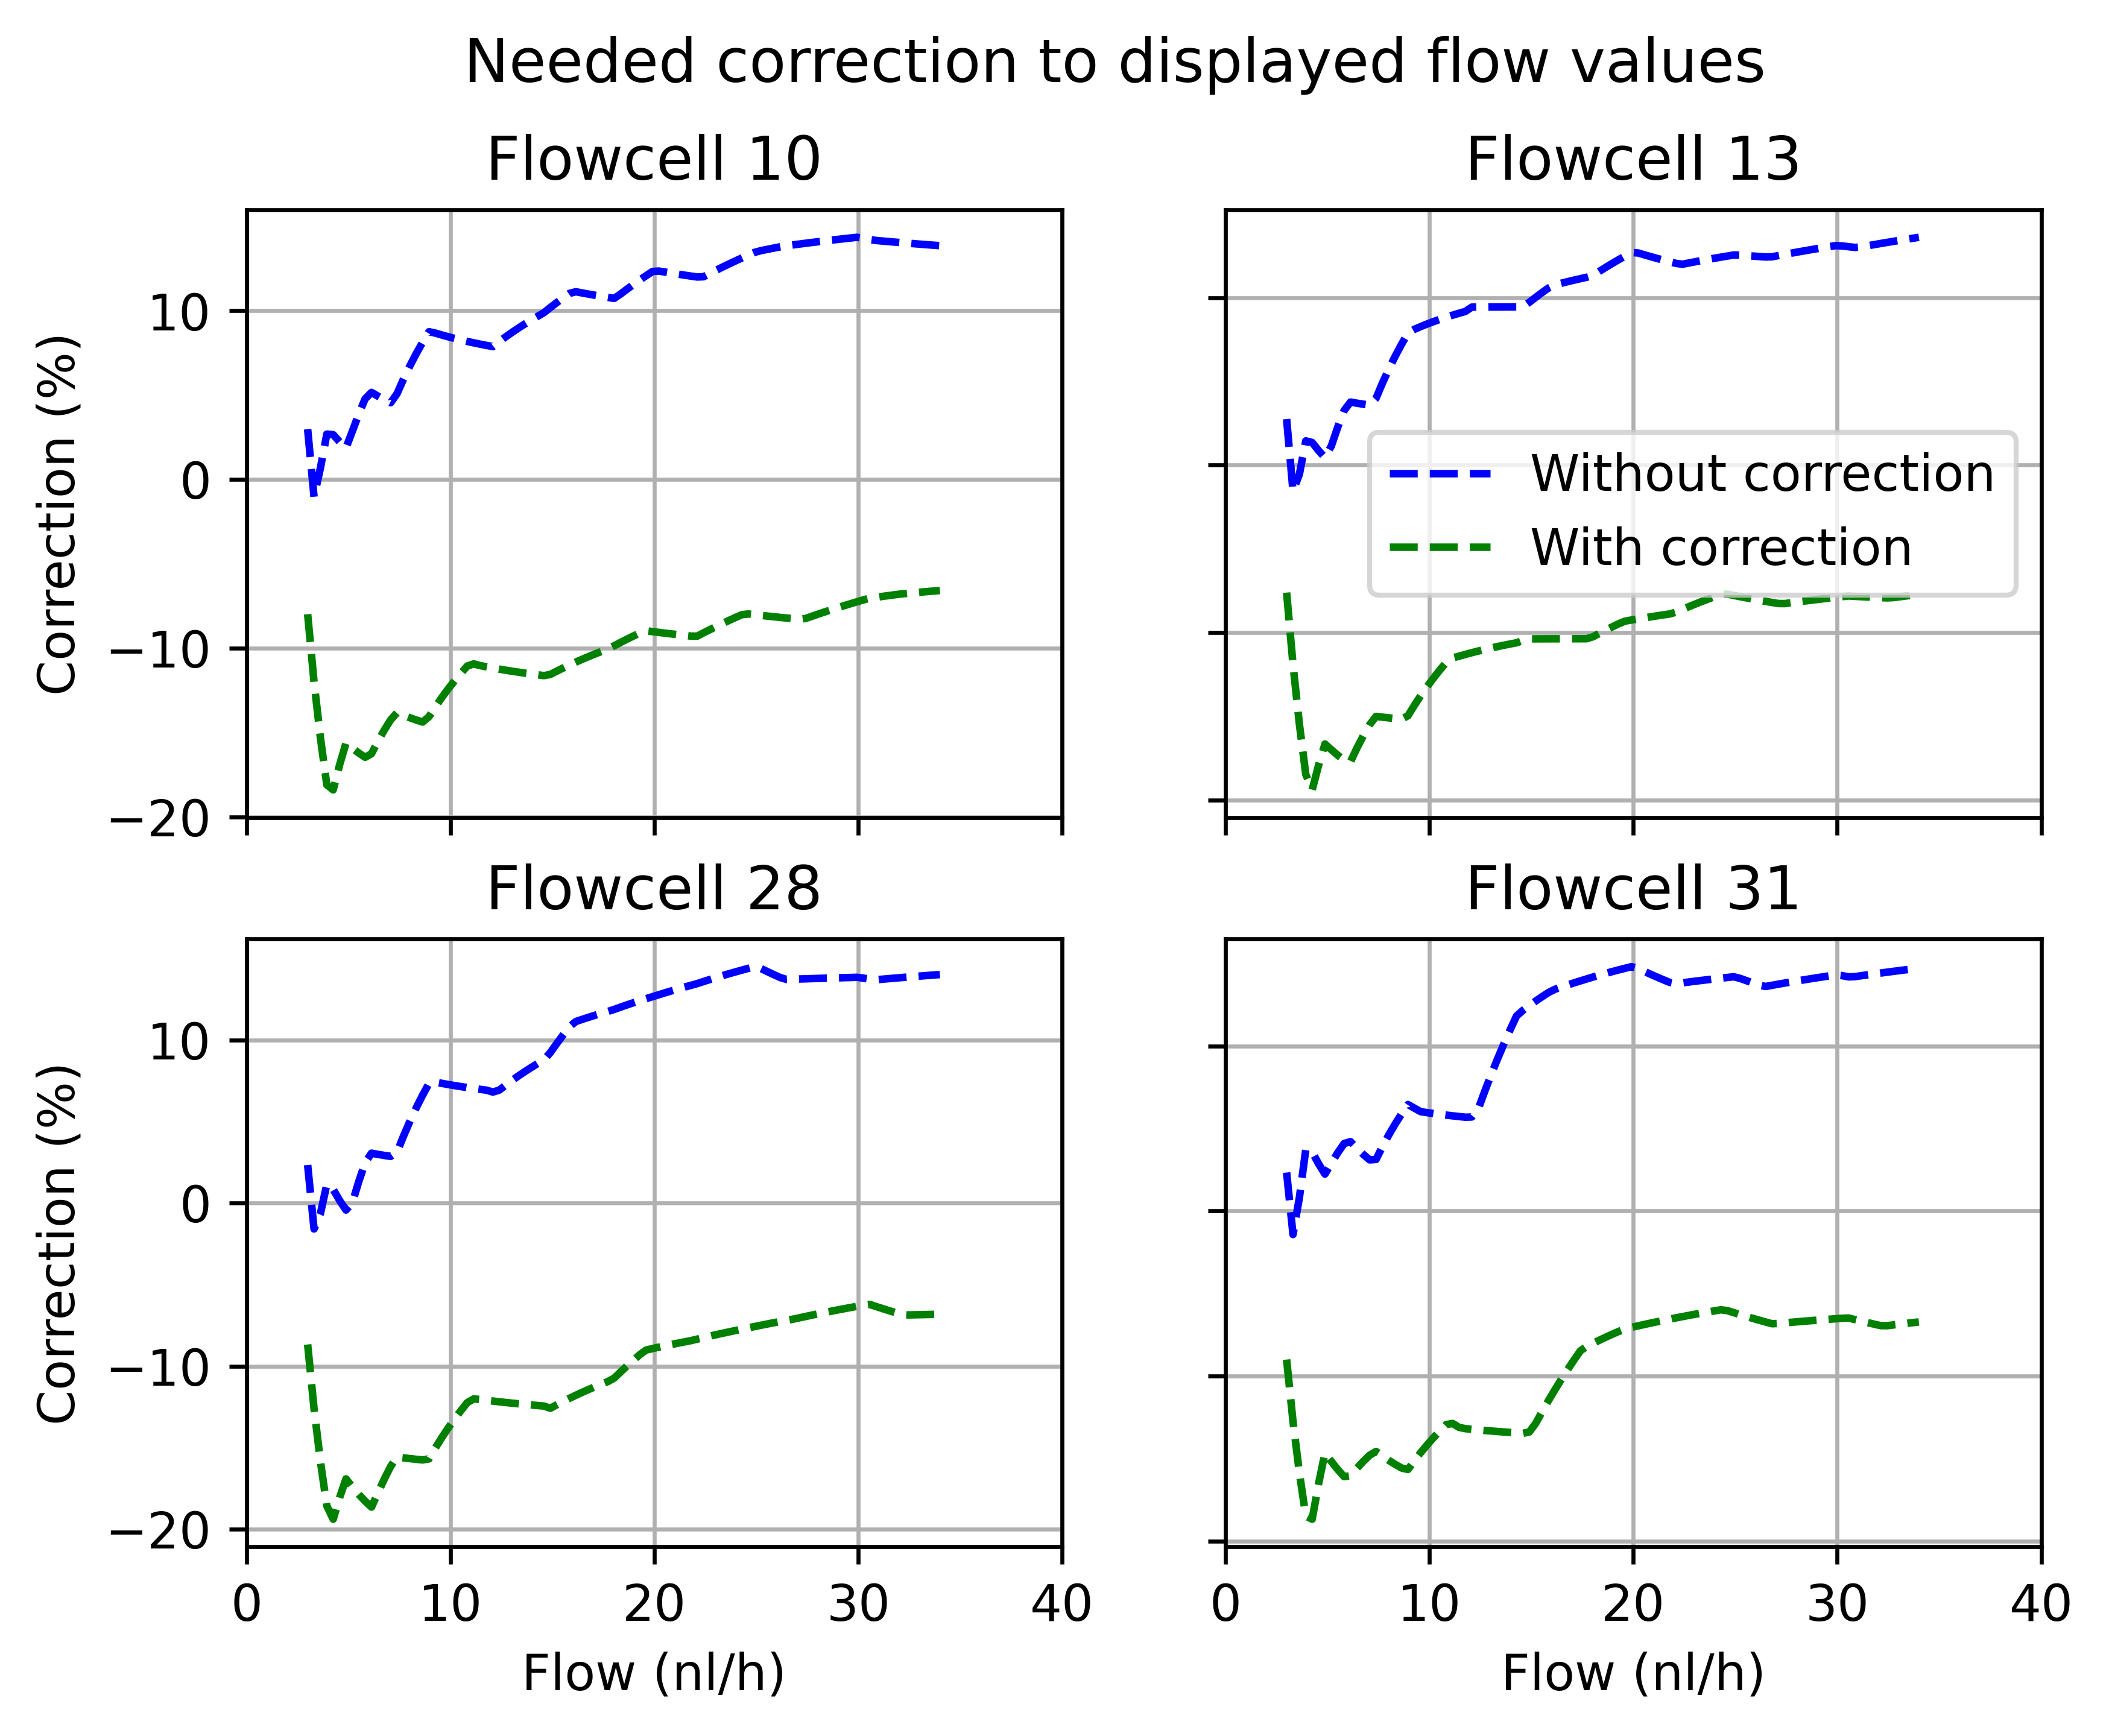

In [97]:
# For given displayed flow in ATLAS RPC: what is error of displayed flow vs correct flow?

def get_flow_error(nb_flowcell, flow_displayed):
        '''Return error in % of a flow value displayed for ATLAS RPC'''
        slope = flow_to_slope(flow_displayed, nb_flowcell, 100)
        flow_real = slope_to_flow(slope, nb_flowcell, 70)
        return 100*(flow_real-flow_displayed) / flow_displayed

def get_flow_error_corrected(nb_flowcell, flow_displayed):
        '''Return error in % of a flow value displayed for ATLAS RPC after proposed correction'''
        slope = flow_to_slope(flow_displayed, nb_flowcell, 100, correction_factor=1.221)
        flow_real = slope_to_flow(slope, nb_flowcell, 70)
        return 100*(flow_real-flow_displayed) / flow_displayed

fig, axs = plt.subplots(2, 2)
fig.suptitle('Needed correction to displayed flow values')
for i in range(4):
    nb_flowcell = flowcell_nbs[i]
    ax = axs[i//2, i%2]
    flows = np.linspace(3, 34, 100)
    errors = []
    errors_corrected = []
    for flow in flows:
        errors.append(get_flow_error(nb_flowcell, flow_displayed=flow))
        errors_corrected.append(get_flow_error_corrected(nb_flowcell, flow_displayed=flow))
    ax.plot(flows, errors, 'b--', label='Without correction')
    ax.plot(flows, errors_corrected, 'g--', label='With correction')
    ax.grid()
    if i==1:
        ax.legend()
    ax.set_title(f'Flowcell {nb_flowcell}')


for ax in axs.flat:
    ax.set(xlabel='Flow (nl/h)', ylabel='Correction (%)')
    ax.set_xlim(0, 40)
    # ax.set_ylim(-4, 18)
for ax in axs.flat:
    ax.label_outer()
